In [41]:
import zipfile
import os

In [42]:
!wget --no-check-certificate \
    "https://github.com/TanviKandalla/recommendersys/archive/refs/heads/main.zip" \
            -O "/tmp/genres.zip"


zip_ref = zipfile.ZipFile('/tmp/genres.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2022-05-30 06:03:26--  https://github.com/TanviKandalla/recommendersys/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/TanviKandalla/recommendersys/zip/refs/heads/main [following]
--2022-05-30 06:03:26--  https://codeload.github.com/TanviKandalla/recommendersys/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/genres.zip’

/tmp/genres.zip         [  <=>               ]   3.26M  14.6MB/s    in 0.2s    

2022-05-30 06:03:26 (14.6 MB/s) - ‘/tmp/genres.zip’ saved [3415441]



In [43]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans


In [44]:
df = pd.read_csv("/tmp/recommendersys-main/features.csv")

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1119 non-null   object 
 1   title             1119 non-null   object 
 2   all_artists       1119 non-null   object 
 3   popularity        1119 non-null   int64  
 4   release_date      1119 non-null   object 
 5   danceability      1119 non-null   float64
 6   energy            1119 non-null   float64
 7   key               1119 non-null   int64  
 8   loudness          1119 non-null   float64
 9   mode              1119 non-null   int64  
 10  acousticness      1119 non-null   float64
 11  instrumentalness  1119 non-null   float64
 12  liveness          1119 non-null   float64
 13  valence           1119 non-null   float64
 14  tempo             1119 non-null   float64
 15  duration_ms       1119 non-null   int64  
 16  time_signature    1119 non-null   int64  


In [46]:
df.head()

,id,title,all_artists,popularity,release_date,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,429hKgsnnsIVn9ohgjj0II,Medicine,James Arthur,57,2021-11-05,0.496,0.732,10,-4.529,1,0.23600,0.000000,0.0905,0.325,143.981,208982,4
1,5nujrmhLynf4yMoMtj8AQF,Levitating (feat. DaBaby),DaBaby,84,2020-03-27,0.702,0.825,6,-3.787,0,0.00883,0.000000,0.0674,0.915,102.977,203064,4
2,0ClPIeT6MSgfSgQ9ZrJbAq,Cheating on You,Charlie Puth,75,2019-10-01,0.749,0.535,4,-6.785,1,0.01310,0.000036,0.0982,0.601,123.042,196607,4
3,62tHYGbBOvOkpgmEXDlgu8,Who's In Your Head,Jonas Brothers,62,2021-10-29,0.704,0.778,5,-5.331,1,0.00447,0.000000,0.0731,0.821,101.025,183537,4
4,6ZuahEctZD6w75peme58hm,Wonder,Shawn Mendes,71,2020-12-04,0.442,0.631,1,-5.096,0,0.13600,0.000023,0.1330,0.129,139.774,172693,4


In [47]:
df = df.drop(columns = ["title","id"])

In [48]:
artist = pd.value_counts(df.all_artists)
artist

Hiroyuki Sawano    28
Shreya Ghoshal     10
Justin Bieber      10
KOHTA YAMAMOTO     10
Sid Sriram          9
                   ..
A.R. Rahman         1
Deepa Miriam        1
Vijay Yesudas       1
Haricharan          1
NOYSE               1
Name: all_artists, Length: 778, dtype: int64

In [49]:
df["release_date"] = pd.to_datetime(df["release_date"])

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   all_artists       1119 non-null   object        
 1   popularity        1119 non-null   int64         
 2   release_date      1119 non-null   datetime64[ns]
 3   danceability      1119 non-null   float64       
 4   energy            1119 non-null   float64       
 5   key               1119 non-null   int64         
 6   loudness          1119 non-null   float64       
 7   mode              1119 non-null   int64         
 8   acousticness      1119 non-null   float64       
 9   instrumentalness  1119 non-null   float64       
 10  liveness          1119 non-null   float64       
 11  valence           1119 non-null   float64       
 12  tempo             1119 non-null   float64       
 13  duration_ms       1119 non-null   int64         
 14  time_signature    1119 n

In [51]:
df['release_date'] = df['release_date'].apply(lambda x: x.value)

Normalizing the features

In [52]:
from sklearn.preprocessing import MinMaxScaler

In [53]:
float_cols = df.dtypes[df.dtypes == 'float64'].index.values
pop = df[["popularity"]].reset_index(drop = True)
scaler = MinMaxScaler()
pop_scaled = pd.DataFrame(scaler.fit_transform(pop), columns = pop.columns) * 0.2

# Scale audio columns
floats = df[float_cols].reset_index(drop = True)
scaler = MinMaxScaler()
floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2


In [54]:
df_minus_artists = df.drop(['all_artists'],axis = 1)

Testing out the clustering to see if it works for 10 clusters.

In [55]:
from sklearn.cluster import KMeans
k = KMeans(n_clusters = 10)

k.fit(df_minus_artists)

KMeans(n_clusters=10)

In [56]:
k.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [57]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12463 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12480 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12463 missing from current font.
  font.set_text

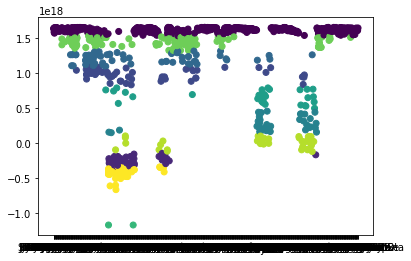

In [58]:
plt.scatter(df.iloc[:,0],df.iloc[:,2], c=k.labels_)

We check for the optimal number of clusters using both silhouette_score & davies_bouldin_score

In [59]:
from sklearn.metrics import silhouette_score

ss=[]
for i in range(25,50):
    k = KMeans(n_clusters = i).fit(df_minus_artists)
    ss.append(silhouette_score(df_minus_artists,k.labels_))
index  = np.array(ss).argmax()
index

24

In [60]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(df_minus_artists,k.labels_)

0.4439189682914081

In [61]:
ds=[]
for i in range(25,50):
    k = KMeans(n_clusters = i).fit(df_minus_artists)
    ds.append(davies_bouldin_score(df_minus_artists,k.labels_))
    index  = np.array(ds).argmin()
index

22

Choose final number of clusters accordingly

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12463 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12480 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12463 missing from current font.
  font.set_text

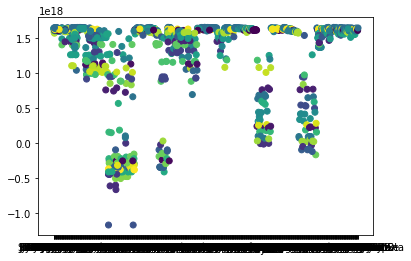

In [62]:
k_final = KMeans(n_clusters = 49).fit(df_minus_artists)
plt.scatter(df.iloc[:,0],df.iloc[:,2], c=k_final.labels_)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   all_artists       1119 non-null   object 
 1   popularity        1119 non-null   int64  
 2   release_date      1119 non-null   int64  
 3   danceability      1119 non-null   float64
 4   energy            1119 non-null   float64
 5   key               1119 non-null   int64  
 6   loudness          1119 non-null   float64
 7   mode              1119 non-null   int64  
 8   acousticness      1119 non-null   float64
 9   instrumentalness  1119 non-null   float64
 10  liveness          1119 non-null   float64
 11  valence           1119 non-null   float64
 12  tempo             1119 non-null   float64
 13  duration_ms       1119 non-null   int64  
 14  time_signature    1119 non-null   int64  
dtypes: float64(8), int64(6), object(1)
memory usage: 131.3+ KB


Checking whether onehotencoding gives better results than just deleting the artists column

In [64]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')

encoder_df = pd.DataFrame(encoder.fit_transform(df[['all_artists']]).toarray())

#merge one-hot encoded columns back with original DataFrame
final_df = df.join(encoder_df)
df_OHE = final_df.drop(['all_artists'], axis = 1)

In [65]:
df_OHE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Columns: 792 entries, popularity to 777
dtypes: float64(786), int64(6)
memory usage: 6.8 MB


In [66]:
from sklearn.cluster import KMeans
kOHE = KMeans(n_clusters = 10)

kOHE.fit(df_minus_artists)

KMeans(n_clusters=10)

In [67]:
from sklearn.metrics import silhouette_score

ssOHE=[]
for i in range(25,50):
    kOHE = KMeans(n_clusters = i).fit(df_OHE)
    ssOHE.append(silhouette_score(df_OHE,kOHE.labels_))
    index  = np.array(ss).argmax()
index

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

24

In [68]:
dsOHE=[]
for i in range(25,50):
    k = KMeans(n_clusters = i).fit(df_OHE)
    dsOHE.append(davies_bouldin_score(df_OHE,kOHE.labels_))
    index  = np.array(ds).argmin()
index

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

22

In [69]:
k_dropped = KMeans(n_clusters = 49).fit(df_minus_artists)
silhouette_score(df_minus_artists, k_dropped.labels_)

0.6140470951592083

In [70]:
k_OHE = KMeans(n_clusters = 49).fit(df_OHE)
silhouette_score(df_OHE,k_dropped.labels_)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.6140470951592083

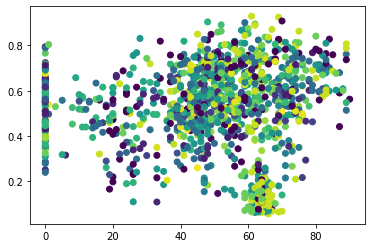

In [71]:
#So, one hot encoding did not make any significant difference, we can simply drop the column to avoid using too much computational power

df_final = df_minus_artists
k_final = KMeans(n_clusters = 49).fit(df_final)
plt.scatter(df_final.iloc[:,0],df_final.iloc[:,2], c=k_final.labels_)